In [9]:
# Dependencies
# Dependencies
import numpy as np
#import tweepy
import time
import json
import requests
#from config import consumer_key, consumer_secret, access_token, access_token_secret
from config import api_key, gmap_key
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

In [4]:
#Import Nutrition Facts  from file 
# load CSV
nutr_file = "Nutrition Data for Fast Food 2017.csv"
nutr_pd = pd.read_csv(nutr_file, encoding='iso-8859-1', low_memory=False)
restu_list=nutr_pd.Fast_Food_Restaurant.unique()
print(restu_list)

["McDonald's" 'Burger King' "Wendy's" 'Chick-fil-A' 'Jack in the Box'
 'Sonic' 'Dairy Queen' "Carl's Jr." "Hardee's" 'White Castle'
 'Whataburger' 'In-N-Out Burger']


In [6]:
####This Block of Code will take a couple minutes to run############

#Set header for YelpFusion API
headers = {'Authorization': 'Bearer {0}'.format(api_key)}

#set an empty list to append dictionary of each Fast Food and their rating 
restaurants_rating = []

#Loop through the restaurants to check if it exists in SF
for restaurant in restu_list:
    
    #Set parameters
    params = {
        "term": restaurant,
        "location": "San Francisco",
        "state": "CA",
        "country": "US",
        "limit": 15
    }

    # Build the endpoint URL (Checks all ice cream shops)
    base_url = "https://api.yelp.com/v3/businesses/search"

    # Run a request to endpoint and convert result to json
    yelp_data = requests.get(base_url, params=params, headers=headers)
    yelp_data = yelp_data.json()
        
    #Loop through all the businesses returned and find which restaurants are in SF    
    for business in yelp_data['businesses']:

        city = get_city(business["id"])
        
        #Since the results returned are 'best matches', filter out all the restaurants that have the same name and is located in SF
        if business['name'] in restaurant and business['is_closed'] == False and city == "San Francisco":
            
            #Append a dictionary containing the fast food and it's rating
            restaurants_rating.append({"Fast Food": restaurant,
                               "Rating": business['rating'],
                                "Latitude": business['coordinates']['latitude'],
                                "Longitude": business['coordinates']['longitude']})

pprint(restaurants_rating)

[{'Fast Food': "McDonald's", 'Rating': 2.0},
 {'Fast Food': "McDonald's", 'Rating': 3.0},
 {'Fast Food': "McDonald's", 'Rating': 2.5},
 {'Fast Food': "McDonald's", 'Rating': 2.0},
 {'Fast Food': "McDonald's", 'Rating': 2.5},
 {'Fast Food': "McDonald's", 'Rating': 4.0},
 {'Fast Food': "McDonald's", 'Rating': 2.0},
 {'Fast Food': "McDonald's", 'Rating': 2.0},
 {'Fast Food': "McDonald's", 'Rating': 3.5},
 {'Fast Food': "McDonald's", 'Rating': 2.5},
 {'Fast Food': "McDonald's", 'Rating': 2.0},
 {'Fast Food': "McDonald's", 'Rating': 1.5},
 {'Fast Food': "McDonald's", 'Rating': 1.0},
 {'Fast Food': "McDonald's", 'Rating': 2.0},
 {'Fast Food': 'Burger King', 'Rating': 2.0},
 {'Fast Food': 'Burger King', 'Rating': 2.0},
 {'Fast Food': 'Burger King', 'Rating': 1.5},
 {'Fast Food': 'Burger King', 'Rating': 2.0},
 {'Fast Food': 'Burger King', 'Rating': 1.5},
 {'Fast Food': 'Burger King', 'Rating': 2.0},
 {'Fast Food': 'Burger King', 'Rating': 2.0},
 {'Fast Food': 'Burger King', 'Rating': 2.5},
 {

In [5]:
#Create a dataframe from the dictionary 
restaurant_pd = pd.DataFrame.from_dict(restaurants_rating)

#write to csv
restaurant_pd.to_csv("restaurant_results.csv", index=False)

NameError: name 'restaurants_rating' is not defined

In [6]:
#Read in csv
restaurant_pd = pd.read_csv("restaurant_results.csv")

#Group by the Fast Food
restaurant_group = restaurant_pd.groupby("Fast Food")

#Get the average rating for each restaurant
average_rating = restaurant_group["Rating"].mean()

#Get the number of restaurants
num_restaurants = restaurant_group["Fast Food"].count()

#Create a new dataframe to hold the average rating and number of restaurants
restaurant_df = pd.DataFrame({"Average Rating": average_rating.map("{:,.2f}".format),
                   "Number of Restaurants": num_restaurants})

#Sort by Average Rating descending
restaurant_df = restaurant_df.sort_values("Average Rating", ascending=0)

#Retrieve the columns in the order we want 
restaurant_df = restaurant_df[["Average Rating","Number of Restaurants"]]

#reset the index
restaurant_df = restaurant_df.reset_index()

#Print out the final dataframe
restaurant_df

,Fast Food,Average Rating,Number of Restaurants
0,In-N-Out Burger,4.00,1
1,McDonald's,2.46,12
2,Carl's Jr.,2.00,1
3,Burger King,1.95,10


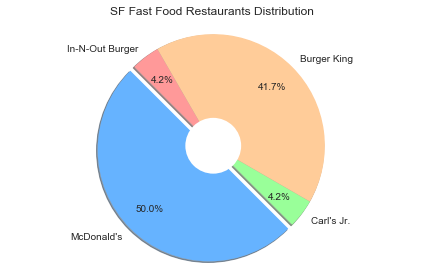

In [87]:
#Plot Pie Chart
restaurant_df
fast_food = restaurant_df["Fast Food"]
num_restaurants = restaurant_df["Number of Restaurants"]
x_axis = np.arange(len(num_restaurants))

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
colors_rating = ['#c2c2f0','#ffb3e6']
explode = (0,0.1,0,0)

plt.pie(num_restaurants, explode=explode, labels=fast_food, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=120, pctdistance=0.75, radius=2)

plt.title("SF Fast Food Restaurants Distribution")

# Create axes which are equal so we have a perfect circle
plt.axis("equal")

#draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()


# Save an image of our chart and print the final product to the screen
plt.savefig("SF_restaurants.png")
plt.show()



In [10]:
#borrowed code and tweaked it from https://github.com/pbugnion/gmaps/issues/210

#Import dependencies to print map
from matplotlib.cm import tab10 # Use the matplotlib tab10 colormap
from matplotlib.colors import to_hex
import ipywidgets as widgets
import gmaps

#Set the api_key to the API key retrieved from google maps
gmaps.configure(api_key=gmap_key)

data = restaurant_pd[["Fast Food", "Latitude", "Longitude"]]
colors = {restaurant: to_hex(tab10(irestaurant)) for irestaurant, restaurant in enumerate(restaurant_pd["Fast Food"].unique())} # generate a colour for each restaurant

# Some CSS hackery to draw a circle of that color next to the year
legend_template = '<span style="color: {color}; font-size: 2em; vertical-align: bottom;">&#9679;</span> {restaurant}'

def draw_map_with_legend():
#     figure = gmaps.figure()

    #Set the parameters of the map
    figure_layout = {
        'width': '400px',
        'height': '400px',
        'border': '1px solid black',
        'padding': '1px'
    }

    #Set a base map of SF
    san_francisco_coordinates = (37.773972, -122.431297)
    #fig = gmaps.figure(center=san_francisco_coordinates, zoom_level=11.5, layout=figure_layout)
    figure = gmaps.figure(layout=figure_layout)
    
    legend_entries = []
    legend_restaurants = []

    for irestaurant, restaurant in enumerate(restaurant_pd["Fast Food"]):

        #restaurant_data = restaurant_pd.loc[restaurant_pd["Fast Food"] == restaurant]
        locations = [[restaurant_pd.iloc[irestaurant]["Latitude"], restaurant_pd.iloc[irestaurant]["Longitude"]]]
        
        #use the average star rating of the restaurants as weights for the scale
        weight = int(restaurant_pd.iloc[irestaurant]["Rating"])
        
        #get the color for the restaurant
        color = colors[restaurant]
        
        #Plot the points
        points_layer = gmaps.symbol_layer(
            locations, 
            fill_color=color, 
            stroke_color=color, 
            fill_opacity=0.3,
            stroke_opacity=0.7,
            scale=weight*2
        )
        figure.add_layer(points_layer)
        
#         info_box_template = f"""
#         <dl>
#         <dt>Name</dt><dd>{restaurant}</dd>
#         <dt>Average Rating</dt><dd>{restaurant_pd.iloc[irestaurant]["Rating"]}</dd>
#         </dl>
#         """

#         marker_layer = gmaps.marker_layer(locations, info_box_content=info_box_template)
#         figure.add_layer(marker_layer)
        
        if restaurant not in legend_restaurants:
            legend_entries.append(legend_template.format(color=color, restaurant=restaurant))
            legend = widgets.HBox(
                [widgets.HTML(legend_entry) for legend_entry in legend_entries],
                layout=widgets.Layout(width='400px', justify_content='space-between')
            )
            legend_restaurants.append(restaurant)
    return widgets.VBox([figure, legend])

draw_map_with_legend()

VBox(children=(Figure(layout=FigureLayout(border='1px solid black', height='400px', padding='1px', width='400px')), HBox(children=(HTML(value='<span style="color: #1f77b4; font-size: 2em; vertical-align: bottom;">&#9679;</span> McDonald\'s'), HTML(value='<span style="color: #ff7f0e; font-size: 2em; vertical-align: bottom;">&#9679;</span> Burger King'), HTML(value='<span style="color: #2ca02c; font-size: 2em; vertical-align: bottom;">&#9679;</span> Carl\'s Jr.'), HTML(value='<span style="color: #d62728; font-size: 2em; vertical-align: bottom;">&#9679;</span> In-N-Out Burger')), layout=Layout(justify_content='space-between', width='400px'))))